# <center>Real NVP [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_utils import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Affine coupling layer:** Let $d=\frac{D}{2}$ (we could use an other d),
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \exp(s(x_{1:d}))\odot x_{d+1:D}+m(x_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        x_{1:d} = z_{1:d} \\
        x_{d+1:D} = \exp(-s(z_{1:d}))\odot (z_{d+1:D}-m(z_{1:d}))
    \end{cases}
\end{equation*}

And $\det J_T(x) = \exp{\sum_j s(x_{1:d})_j}$.

**Batch Norm Layer**: Let $m$ be the mean and $v$ be the variance (of a batch in training time, and of the whole training set in testing time), then a batch norm is:
\begin{equation*}
    x = (z-\beta)\odot e^{-\gamma}\odot (v+\epsilon)^{\frac12}+m
\end{equation*}
with $\gamma$ and $\beta$ some learnable parameters and $\epsilon$ a constant ensuring numerical stability. The invert is:
\begin{equation*}
    z = (x-m)\odot (v+\epsilon)^{-\frac12}\odot e^\gamma +\beta
\end{equation*}
Note that we could put $\gamma$ instead of $e^\gamma$. Then, we have: $\det J_T(x) = e^{\sum_j \gamma_j-\frac12\log(v_j+\epsilon)}$.

A Real NVP is composed of affine coupling layers and batch norm layers. To permute indices, we can just permute even and odd indices (or first and last part of vectors) as it is done here. We could also add permutation or reverse layers.

Possible improvement: Masked convolution: Partitioning is done by using a binary mask $b$:
\begin{equation*}
    y = b\odot x+(1-b)\odot(x\odot\exp(s(b\odot x))+t(b\odot x))
\end{equation*}

## Moons

In [4]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126730


0 2.3270010948181152


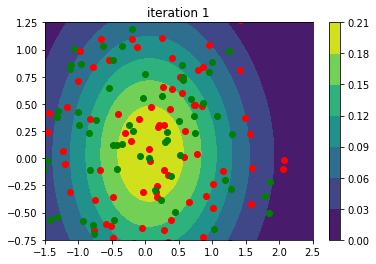

1000 1.2777148485183716


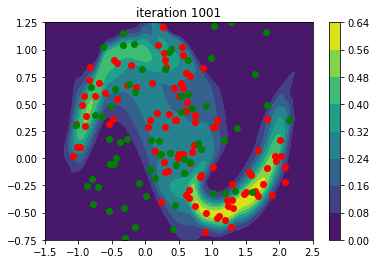

2000 1.2389333248138428


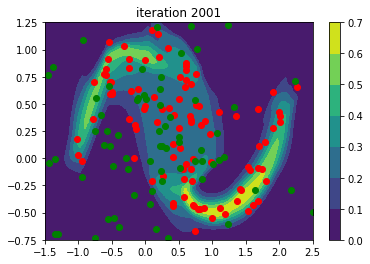

3000 1.2318181991577148


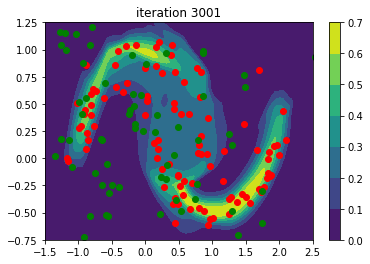

4000 1.160287618637085


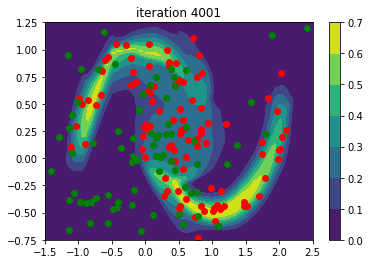

5000 1.2246259450912476


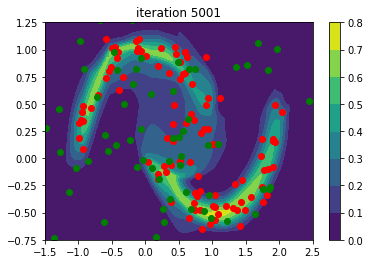

6000 1.0757626295089722


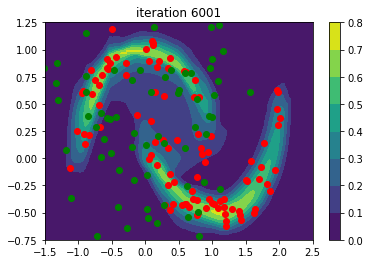

7000 1.1276748180389404


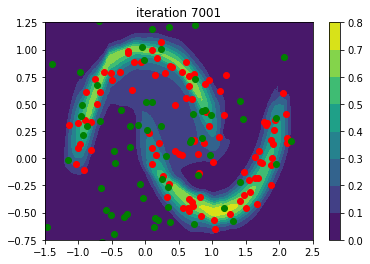

8000 1.1559257507324219


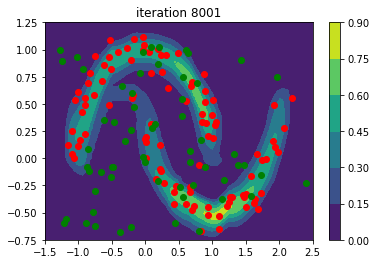

9000 1.106156349182129


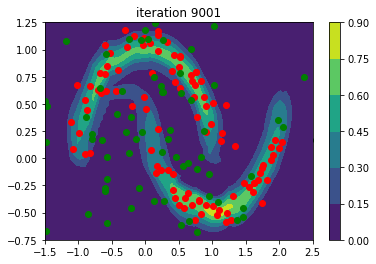

10000 1.0069233179092407


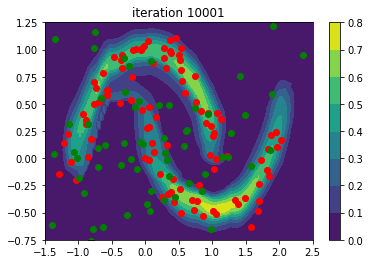

In [5]:
train_loss = train_moons(model,optimizer,base_distr="normal")

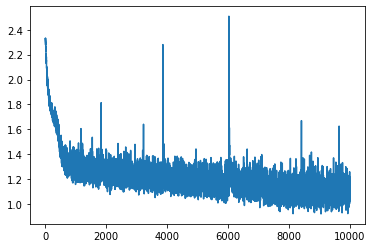

In [6]:
plt.plot(train_loss)
plt.show()

In [7]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126750


0 7.377962112426758


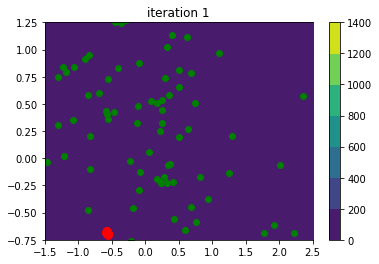

1000 5.40742826461792


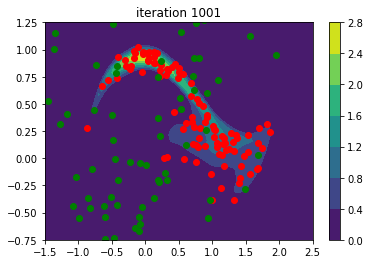

2000 4.423325538635254


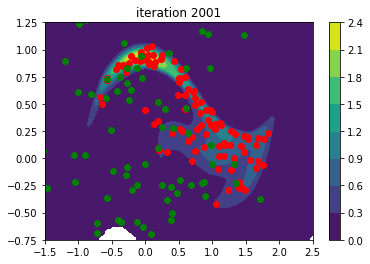

3000 3.769948720932007


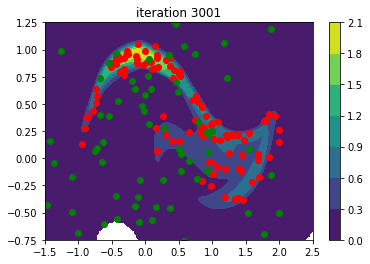

4000 2.9353623390197754


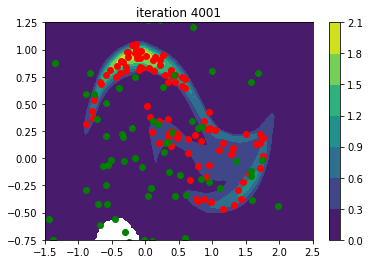

5000 2.595085859298706


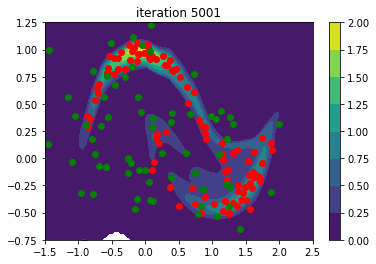

6000 2.097710609436035


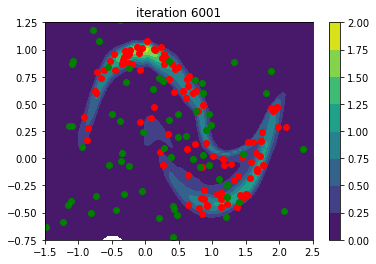

7000 1.685617446899414


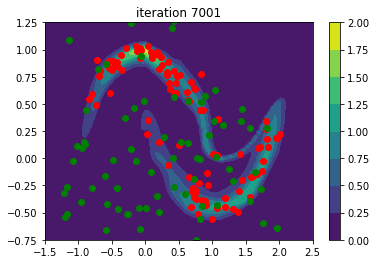

8000 1.5275635719299316


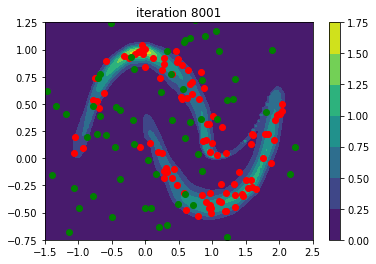

9000 1.4913158416748047


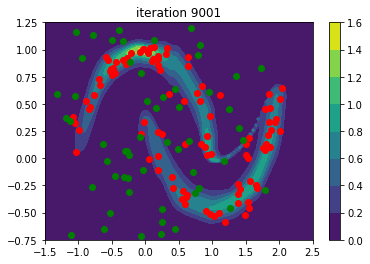

10000 1.1536610126495361


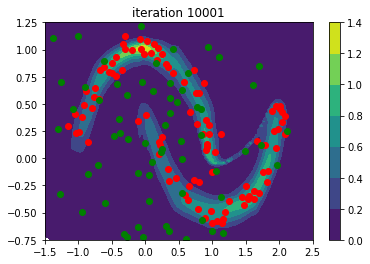

In [9]:
train_loss = train_moons(model,optimizer,base_distr="normal")

## MNIST

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

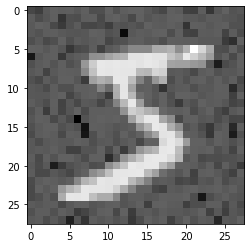

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [ ]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [ ]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  18546160


0 3450.6026785714284


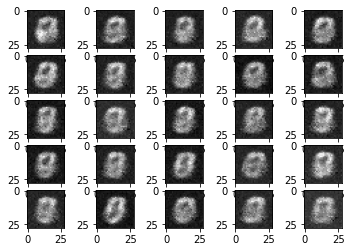

1 3104.6925499108806
2 2868.9698098514127
3 2670.248441456223
4 2496.45841853095
5 2342.318525952825
6 2205.1824318696695
7 2081.797505392957
8 1971.4017633303904
9 1872.1541206668944
10 1783.2155748704859
11 1703.4790681948793
12 1632.2315304233575
13 1568.786696574327
14 1512.1459601754063
15 1462.5960175406449
16 1418.760185192897
17 1380.9405590455924
18 1347.7599842583954
19 1320.1821156320796
20 1296.2730525490572
21 1277.1514348597416
22 1260.9844122197328
23 1248.2552789553904
24 1238.3350653089185
25 1230.889887372568
26 1225.0512461062433
27 1221.2402614438965
28 1218.2247824597714
29 1215.9133043106176
30 1214.376861507196
31 1212.6522385977478
32 1211.2208871414412
33 1210.0056862902286
34 1208.874072369736
35 1207.7682111207357
36 1206.646737104794
37 1205.3611641499533
38 1204.3744948006897
39 1203.0097593783316
40 1202.4274907549307
41 1201.1480450009994
42 1200.4042919297208
43 1199.3098152339585
44 1197.8718862960588
45 1197.4330945370803
46 1196.8713423153486
47 1195.

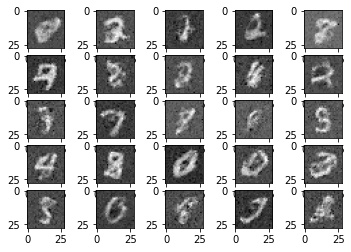

51 1191.5316552526153
52 1190.8012898329225
53 1190.098894131463
54 1189.5081956289978
55 1188.5589336728744
56 1187.9929881146722
57 1186.9687984116804
58 1186.3158612281784
59 1185.442359908049
60 1184.7668204561733
61 1184.013201292644
62 1183.3951944379664
63 1182.754513998784
64 1181.76446910606
65 1181.2965827079724
66 1180.5656134436633
67 1179.9113248975546
68 1179.085749579391
69 1178.8069360403617
70 1177.6984241217185
71 1177.4680956614804
72 1176.8050708892756
73 1176.3083339927039
74 1175.5416949501932
75 1175.1721961828691
76 1174.2779556632297
77 1173.9576163546108
78 1173.3798562641591
79 1172.7726915436767
80 1172.5034622159849
81 1171.6517104939865
82 1170.979446638876
83 1170.6022308935235
84 1170.1722058131497
85 1169.7469198719016
86 1169.297624600213
87 1168.5690873721514
88 1168.2981438545276
89 1167.517423519956
90 1167.395904475946
91 1166.8352766545343
92 1166.537360803405
93 1166.0052883253932
94 1165.0726128356544
95 1165.2429386618803
96 1165.0762169030684


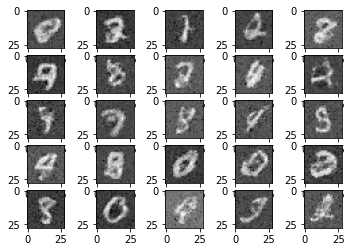

In [ ]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [ ]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [ ]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

-2.2123762962266316


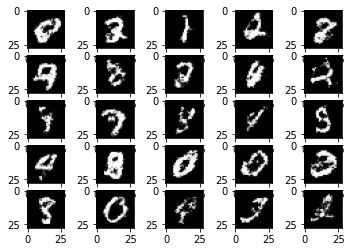

In [ ]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>

[1] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)